In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.transpiler.passes import Depth
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.circuit import Delay

import matplotlib.pyplot as plt
import math
import numpy as np

import sys
import os

sys.path.append(os.path.abspath("..\\..\\.."))
from objects.steane_code_circuit import SteaneCodeCircuit
from functions import *


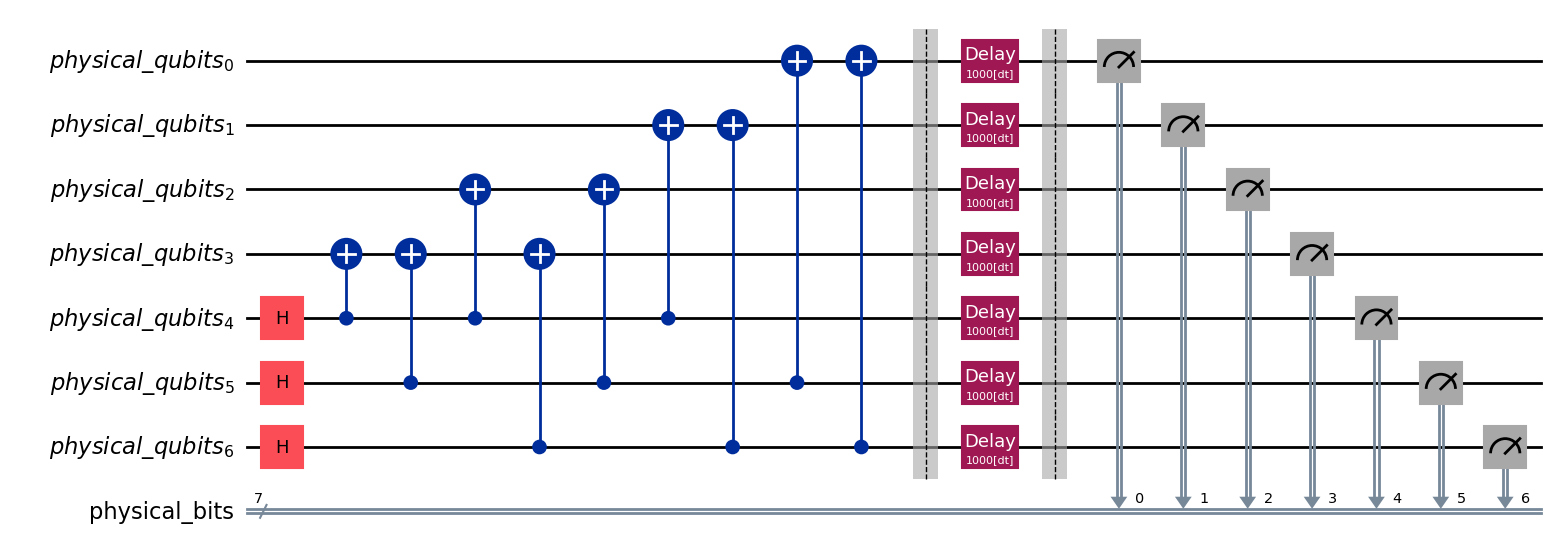

In [2]:
def load_circuit(delay):
    qc = SteaneCodeCircuit(1)

    qc.encode(append=True, initial_state='0')

    qc.barrier()
    qc.delay(delay)
    qc.barrier()
    
    qc.measure_all(basis='all')

    return qc

qc = load_circuit(1000)
qc.draw_physical_circuit('mpl')

In [3]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_sherbrooke")

In [4]:
phy_qc = qc.physical_quantum_circuit
isa_circuit = transpile(phy_qc, backend, scheduling_method="asap", optimization_level=3)
print(f"Circuit Depth: {qc.physical_quantum_circuit.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")


Circuit Depth: 8
Transpiled Circuit Depth: 64


In [5]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.222 ns


In [6]:
# t_array = [0]
# t_array = [t*90_000 for t in range(0, 3)]
t_array = [t*180_000 for t in range(0, 3)]
print([round(t*dt * 10**(-3), 3) for t in t_array])

[0.0, 40.0, 80.0]


In [7]:
# circuits = []

# for t in t_array:

#     qc = load_circuit(t)

#     isa_circuit = get_transpile(qc.physical_quantum_circuit, backend, iterations=50,
#                                 # initial_layout=[122, 123, 121, 111, 124, 120, 125]
#                                 )
    
#     circuits.append(isa_circuit)

#     print(f"Circuit Depth: {circuits[-1].depth()}")
#     print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} us")
#     print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} us")
#     print(get_layout(circuits[-1], qb_len=7))
#     print('\n')

In [8]:
simulation_result = sampler_simulation(qc.physical_quantum_circuit, 12800).data[qc.physical_bit_register.name].get_counts()

print(simulation_result)


{'0110011': 1630, '1100110': 1563, '0101101': 1560, '1001011': 1652, '0000000': 1670, '0011110': 1548, '1111000': 1573, '1010101': 1604}


In [9]:
sampler = SamplerV2(backend=backend)
shots = 12800
# job = sampler.run(circuits, shots=shots)
# job = service.job('cz13hbnkvm9g008fn4e0') # sherbrooke, shots = 12800, t_array = [0]
# job = service.job('cz1r21g1xvhg008drv7g') # t_array = [t*90_000 for t in range(0, 3)]
# job = service.job('cz1r2bh39f40008ry44g') # otra iteracion
# job = service.job('cz1rcd1h0kc00088dykg') # kyiv, t_array = [0]
job = service.job('cz2kbx7kvm9g008fwfg0') # sherbrooke, t_array = [t*180_000 for t in range(0, 3)]


pub_result = job.result()

In [10]:
states = [bin(i)[2:].zfill(7) for i in range(2**7)]
valid_states = ['0000000', '1010101', '0001111', '1100110', '1101001', '0110011', '1011010', '0111100']

results = extract_results_IBM(pub_result, type='percentage')[qc.physical_bit_register.name]


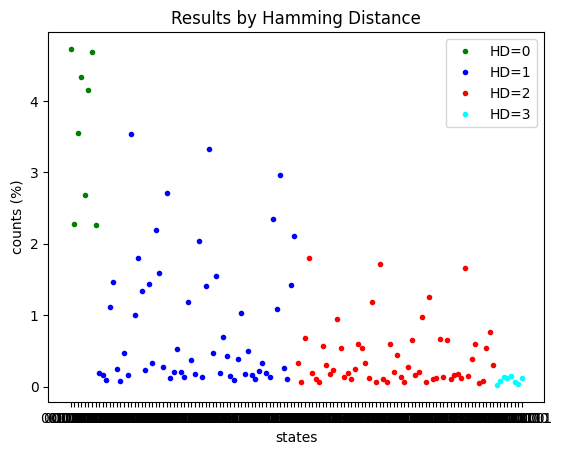

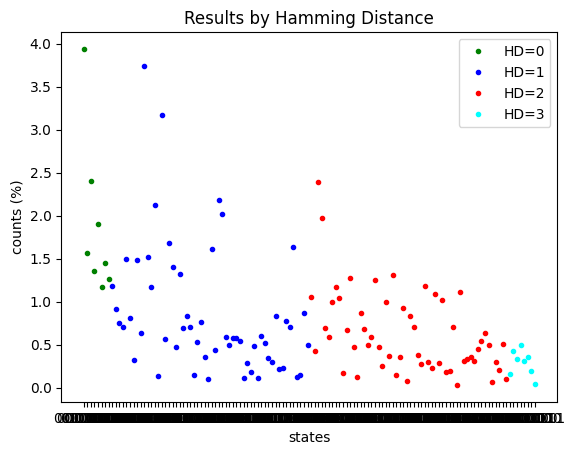

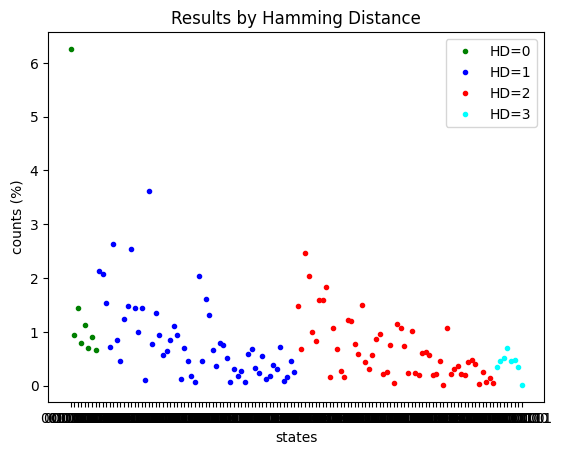

In [11]:
for r in results:
    plot_results_hamming_distance(r, 7, valid_states)

0.15617187499999996


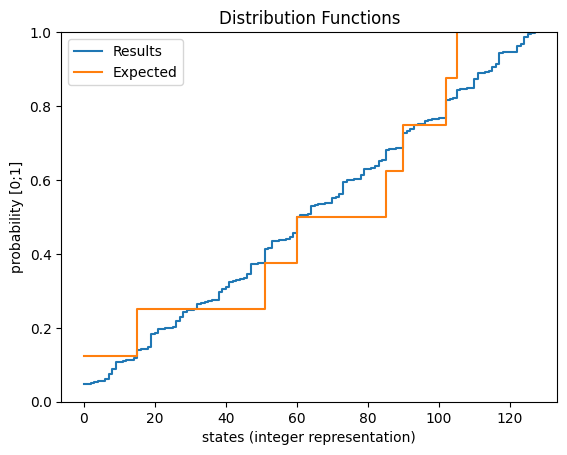

0.28179687499999995


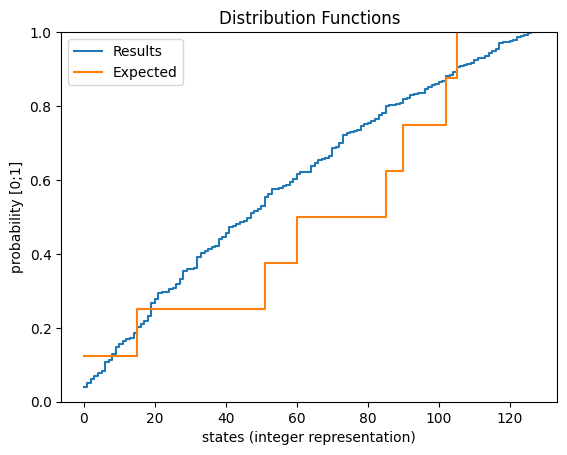

0.3715625


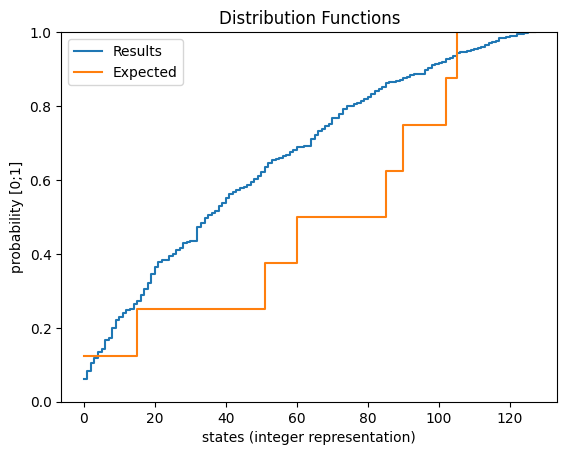

In [12]:
for r in results:
    print(calculate_test_ks(r, generate_uniform_distribution(7, valid_states)))
    plot_distribution_functions(r, generate_uniform_distribution(7, valid_states), style='step')

In [13]:
print_order_results(results[0], valid_states=valid_states, limit=32)

state: result, HD, error positions
0000000: 4.727%, 0, [[]]
1100110: 4.68%, 0, [[]]
0111100: 4.328%, 0, [[]]
1011010: 4.148%, 0, [[]]
0110011: 3.547%, 0, [[]]
0010011: 3.531%, 1, [[1]]
1001001: 3.32%, 1, [[1]]
1110101: 2.961%, 1, [[1]]
0101111: 2.703%, 1, [[1]]
1010101: 2.688%, 0, [[]]
1101110: 2.352%, 1, [[3]]
0001111: 2.281%, 0, [[]]
1101001: 2.258%, 0, [[]]
0100110: 2.195%, 1, [[0]]
1111100: 2.109%, 1, [[0]]
1000000: 2.031%, 1, [[0]]
0001001: 1.797%, 2, [[3, 6], [4, 5], [0, 1]]
0011010: 1.797%, 1, [[0]]
0110101: 1.711%, 2, [[0, 1], [4, 5], [3, 6]]
1101111: 1.664%, 2, [[0, 1], [3, 6], [4, 5]]
0101001: 1.586%, 1, [[0]]
1001111: 1.555%, 1, [[0]]
0001000: 1.461%, 1, [[3]]
0100000: 1.43%, 1, [[1]]
1111010: 1.422%, 1, [[1]]
1000110: 1.406%, 1, [[1]]
0011100: 1.336%, 1, [[1]]
1010011: 1.258%, 2, [[4, 5], [0, 1], [3, 6]]
0101110: 1.188%, 2, [[1, 6], [0, 3], [2, 5]]
0111011: 1.188%, 1, [[3]]
0000111: 1.109%, 1, [[3]]
1110011: 1.086%, 1, [[0]]


In [14]:
tvd = [calculate_tvd(r, generate_uniform_distribution(7, valid_states), percentage=True) for r in results]
for i in range(len(tvd)):
    print(f"TVD step{i}: {round(tvd[i]*100,2)}%")

TVD step0: 71.34%
TVD step1: 84.94%
TVD step2: 87.15%


In [17]:
ks = [calculate_test_ks(r, generate_uniform_distribution(7, valid_states)) for r in results]
for i in range(len(ks)):
    print(f"KS test, step{i}: {round(ks[i]*100,2)}%")

KS test, step0: 15.62%
KS test, step1: 28.18%
KS test, step2: 37.16%
